In [190]:
# Learning Practice 6 for the University of Tulsa's QM-7063 Data Mining Course
# Logistic Regression for Classification
# # Professor: Dr. Abdulrashid, Spring 2023
# Noah L. Schrick - 1492657

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from dmba import stepwise_selection
from dmba import regressionSummary
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import seaborn as sns
from dmba.metric import AIC_score

# Problem 10.3

A company that manufactures riding mowers wants to identify the best sales prospects for an intensive sales campaign. In particular, the manufacturer is interested in classifying households as prospective owners or nonowners on the basis of Income (in $1000s) and Lot Size (in 1000 ft2). The marketing expert looked at a random sample of 24 households, given in the file RidingMowers.csv. 

Use all the data to fit a logistic regression of ownership on the two predictors.

a. What percentage of households in the study were owners of a riding mower?  
b. Create a scatter plot of Income vs. Lot Size using color or symbol to distinguish owners from nonowners. From the scatter plot, which class seems to have a higher average income, owners or nonowners?  
c. Among nonowners, what is the percentage of households classified correctly?  
d. To increase the percentage of correctly classified nonowners, should the cutoff probability be increased or decreased?  
e. What are the odds that a household with a $60K income and a lot size of 20,000ft2 is an owner?  
f. What is the classification of a household with a $60K income and a lot size of 20,000 ft2? Use cutoff = 0.5.  
g. What is the minimum income that a household with 16,000 ft2 lot size should have before it is classified as an owner?  

In [191]:
mowers_df = pd.read_csv('RidingMowers.csv')

# a
owner_pctg = mowers_df['Ownership'].value_counts(normalize=True) * 100
print(owner_pctg)


Owner       50.0
Nonowner    50.0
Name: Ownership, dtype: float64


Ownership
Nonowner    57.400
Owner       79.475
Name: Income, dtype: float64


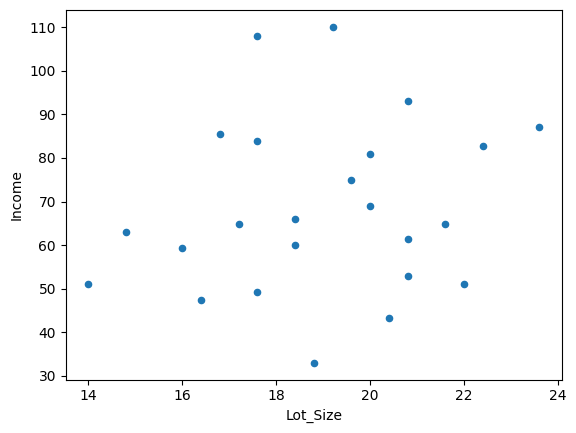

In [12]:
# b 
mowers_df.plot.scatter(x='Lot_Size', y='Income', legend=True)
owner_inc = mowers_df.groupby('Ownership')['Income'].mean()
print(owner_inc)

In [25]:
# c
predictors = ['Lot_Size', 'Income']
outcome = 'Ownership'

X = pd.get_dummies(mowers_df[predictors], drop_first=True)
y = mowers_df[outcome]
classes = ['Owner', 'Nonowner']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.25, 
                                                      random_state=1)

logit_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_full.fit(train_X, train_y)

logit_reg_pred = logit_full.predict_proba(valid_X)
full_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_full.predict(valid_X)})
full_result = full_result.sort_values(by=['p(1)'], ascending=False)

subset_df = full_result.loc[full_result['actual'] == 'Nonowner']

num_corr = 0
total = 0
for index, row in subset_df.iterrows():    
    if (row['actual'] == row['predicted']):
        num_corr += 1
        total += 1
    else:
        total += 1

print("Classified Correctly:", num_corr/total*100.00, "%")
print(subset_df)



Classified Correctly: 80.0 %
      actual      p(0)      p(1) predicted
13  Nonowner  0.418583  0.581417     Owner
14  Nonowner  0.838644  0.161356  Nonowner
17  Nonowner  0.936463  0.063537  Nonowner
18  Nonowner  0.958456  0.041544  Nonowner
20  Nonowner  0.979416  0.020584  Nonowner


# d
Cutoff percentage should be decreased.

In [43]:
# e
data = [[20, 60]]
pred = pd.DataFrame(data, columns=['Lot_Size', 'Income'])

logit_reg_pred_s = logit_full.predict_proba(pred)
p0 = [p[0] for p in logit_reg_pred_s]
p1 = [p[1] for p in logit_reg_pred_s]
full_result = pd.DataFrame({'p(0)': p0,
                            'p(1)': p1,
                            'predicted': logit_full.predict(pred)})
print("Odds of event:", np.exp(p1[0]))


Odds of event: 1.7719334017055501


In [56]:
# f
print(full_result)


Nonowner


In [57]:
# g. What is the minimum income that a household with 16,000 ft2 lot size should have before it is classified as an owner? 
init = 60
while(True):
    data = [[16, init]]
    pred = pd.DataFrame(data, columns=['Lot_Size', 'Income'])

    logit_reg_pred_s = logit_full.predict_proba(pred)
    p0 = [p[0] for p in logit_reg_pred_s]
    p1 = [p[1] for p in logit_reg_pred_s]
    full_result = pd.DataFrame({'p(0)': p0,
                                'p(1)': p1,
                                'predicted': logit_full.predict(pred)})
    if(full_result['predicted'][0] == 'Nonowner'):
        init = init + 0.025
    else:
        print(init)
        break


94.9000000000068


# Problem 10.4

The file eBayAuctions.csv contains information on 1972 auctions transacted on eBay.com during May–June 2004. The goal is to use these data to build a model that will distinguish competitive auctions from non-competitive ones. A competitive auction is defined as an auction with at least two bids placed on the item being auctioned. The data include variables that describe the item (auction category), the seller (his or her eBay rating), and the auction terms that the seller selected (auction duration, opening price, currency, day of week of auction close). In addition, we have the price at which the auction closed. The goal is to predict whether or not an auction of interest will be competitive.

Data preprocessing. Create dummy variables for the categorical predictors.
These include Category (18 categories), Currency (USD, GBP, Euro), EndDay
(Monday–Sunday), and Duration (1, 3, 5, 7, or 10 days).

a. Create pivot tables for the mean of the binary outcome (Competitive?) as a function of the various categorical variables (use the original variables, not the dummies). Use the information in the tables to reduce the number of dummies that will be used in the model. For example, categories that appear most similar with respect to the distribution of competitive auctions could be combined.  
b. Split the data into training (60%) and validation (40%) datasets. Run a logistic model with all predictors with a cutoff of 0.5.  
c. If we want to predict at the start of an auction whether it will be competitive, we cannot use the information on the closing price. Run a logistic model with all predictors as above, excluding price. How does this model compare to the full model with respect to predictive accuracy?  
d. Interpret the meaning of the coefficient for closing price. Does closing price have a practical significance? Is it statistically significant for predicting competitiveness of auctions? (Use a 10% significance level.)  
e. Use stepwise regression as described in Section 6.4 to find the model with the best fit to the training data (highest accuracy). Which predictors are used?  
f. Use stepwise regression to find the model with the highest accuracy on the validation data. Which predictors are used?  
g. What is the danger of using the best predictive model that you found?  
h. Explain how and why the best-fitting model and the best predictive models are the same or different.  
i. Use regularized logistic regression with L1 penalty on the training data. Compare its selected predictors and classification performance to the best-fitting and best predictive models.  
j. If the major objective is accurate classification, what cutoff value should be used?  
k. Based on these data, what auction settings set by the seller (duration, opening price, ending day, currency) would you recommend as being most likely to lead to a competitive auction.  

In [76]:
# Pre-processing
orig_auction_df = pd.read_csv('eBayAuctions.csv')
auction_df = pd.read_csv('eBayAuctions.csv')
auction_df.columns = [c.replace(' ', '_') for c in auction_df.columns]

auction_df['Duration'] = auction_df['Duration'].astype('category')

auction_df['currency'] = auction_df['currency'].astype('category')
new_categories = {1: 'USD', 2: 'GBP', 3: 'Euro'}
auction_df.currency.cat.rename_categories(new_categories, inplace=True)
auction_df = pd.get_dummies(auction_df, prefix_sep='_', drop_first=True)

category_cols = [col for col in auction_df.columns if 'Category_' in col]
endDay_cols = [col for col in auction_df.columns if 'endDay_' in col]

for col in category_cols:
    auction_df[col] = auction_df[col].astype('category')

for col in endDay_cols:
    auction_df[col] = auction_df[col].astype('category')


/tmp/ipykernel_27606/691198861.py:10: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  auction_df.currency.cat.rename_categories(new_categories, inplace=True)


In [90]:
# a
dur_pivot = orig_auction_df.pivot_table(index =['Duration'],
                                    values =['Competitive?'],
                                    aggfunc ='mean')
print(dur_pivot)

cur_pivot = orig_auction_df.pivot_table(index =['currency'],
                                    values =['Competitive?'],
                                    aggfunc ='mean')
print(cur_pivot)

for col in endDay_cols:
    date_pivot = auction_df.pivot_table(index = [col],
                                        values =['Competitive?'],
                                        aggfunc ='mean')
    print(date_pivot)

for col in category_cols:
    cat_pivot = auction_df.pivot_table(index = [col],
                                        values =['Competitive?'],
                                        aggfunc ='mean')
    print(cat_pivot)


          Competitive?
Duration              
1             0.521739
3             0.450704
5             0.686695
7             0.489142
10            0.544554
          Competitive?
currency              
EUR           0.551595
GBP           0.687075
US            0.519350
            Competitive?
endDay_Mon              
0               0.489466
1               0.673358
            Competitive?
endDay_Sat              
0               0.565083
1               0.427350
            Competitive?
endDay_Sun              
0               0.552020
1               0.485207
            Competitive?
endDay_Thu              
0               0.533333
1               0.603960
            Competitive?
endDay_Tue              
0               0.541366
1               0.532164
            Competitive?
endDay_Wed              
0               0.542963
1               0.480000
                     Competitive?
Category_Automotive              
0                        0.559086
1                     

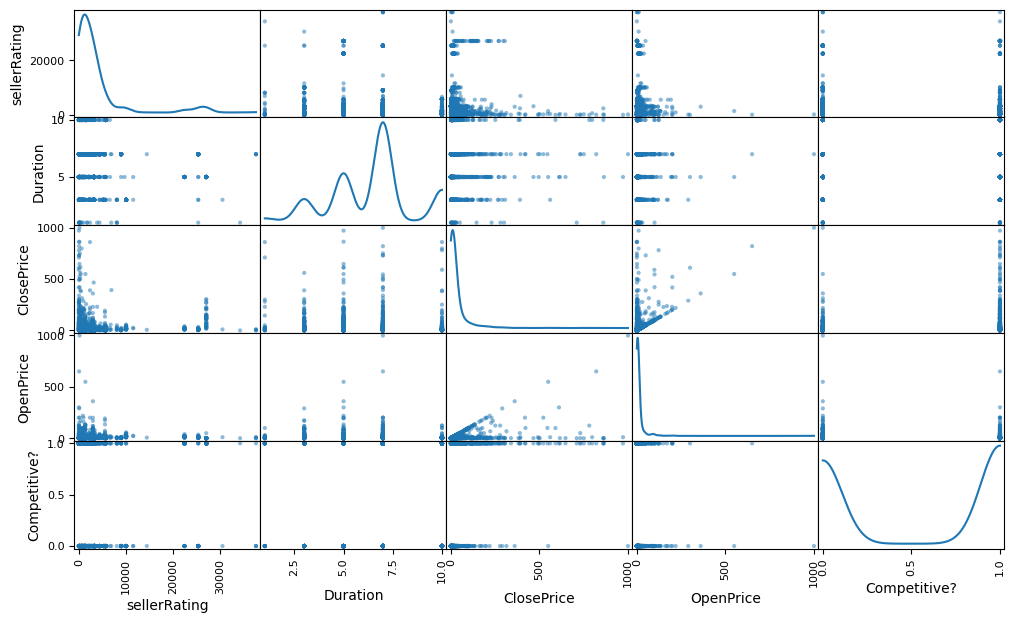

In [93]:
plt=scatter_matrix(orig_auction_df,diagonal='kde',figsize=(12,7))

# Combine open and close price

In [167]:
# b
outcome = auction_df['Competitive?']
predictors = auction_df.drop('Competitive?',axis=1)
X = auction_df.drop(columns=['Competitive?'])


df_dummies=pd.get_dummies(predictors,drop_first=True)
#df_dummies.insert(0,'Intercept',[1]*len(df_dummies))

train_X,valid_X,train_y,valid_y=train_test_split(df_dummies,outcome,test_size=0.40, random_state=1)
train_X_p = train_X
valid_X_p = valid_X


logit_full_p = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_full_p.fit(train_X, train_y)

logit_reg_pred_p = logit_full_p.predict_proba(valid_X)
full_result_p = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_pred_p],
                            'p(1)': [p[1] for p in logit_reg_pred_p],
                            'predicted': logit_full_p.predict(valid_X)})
full_result_p = full_result_p.sort_values(by=['p(1)'], ascending=False)
print(full_result_p)

num_corr = 0
total = 0
for index, row in full_result_p.iterrows():    
    if (row['actual'] == row['predicted']):
        num_corr += 1
        total += 1
    else:
        total += 1

inc_price_pctg = num_corr/total*100.00

print("Classified Correctly:", inc_price_pctg, "%")

      actual      p(0)      p(1)  predicted
480        1  0.000000  1.000000          1
512        1  0.000000  1.000000          1
1664       1  0.000000  1.000000          1
1704       1  0.000000  1.000000          1
1963       1  0.000000  1.000000          1
...      ...       ...       ...        ...
1863       0  0.963370  0.036630          0
1960       0  0.979843  0.020157          0
1955       0  0.995957  0.004043          0
1952       0  0.996900  0.003100          0
1967       0  0.998912  0.001088          0

[789 rows x 4 columns]
Classified Correctly: 76.1723700887199 %


In [130]:
# c
new_predictors = predictors.drop('ClosePrice',axis=1)

df_dummies=pd.get_dummies(new_predictors,drop_first=True)
df_dummies.insert(0,'Intercept',[1]*len(df_dummies))

train_X,valid_X,train_y,valid_y=train_test_split(df_dummies,outcome,test_size=0.40, random_state=1)

logit_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_full.fit(train_X, train_y)

logit_reg_pred = logit_full.predict_proba(valid_X)
full_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_full.predict(valid_X)})
full_result = full_result.sort_values(by=['p(1)'], ascending=False)
print(full_result)

num_corr = 0
total = 0
for index, row in full_result.iterrows():    
    if (row['actual'] == row['predicted']):
        num_corr += 1
        total += 1
    else:
        total += 1

not_inc_price_pctg = num_corr/total*100.00
print("Classified Correctly:", not_inc_price_pctg, "%")
   

print("When not including close price, the model is", inc_price_pctg/not_inc_price_pctg, "times worse")

      actual      p(0)      p(1)  predicted
1772       0  0.030589  0.969411          1
852        1  0.083026  0.916974          1
955        1  0.096801  0.903199          1
1836       1  0.097049  0.902951          1
1622       1  0.099306  0.900694          1
...      ...       ...       ...        ...
1081       1  0.910252  0.089748          0
348        0  0.910385  0.089615          0
1237       1  0.910617  0.089383          0
1955       0  0.940586  0.059414          0
1952       0  0.963785  0.036215          0

[789 rows x 4 columns]
Classified Correctly: 63.37135614702155 %
When not including close price, the model is 1.202 times worse


In [132]:
# d
print('intercept ', logit_full_p.intercept_[0])
print(pd.DataFrame({'coeff': logit_full_p.coef_[0]}, index=X.columns).transpose())


intercept  -0.36315695612599685
       sellerRating  ClosePrice  OpenPrice  Category_Automotive  \
coeff     -0.000046    0.088855  -0.105865             1.758587   

       Category_Books  Category_Business/Industrial  \
coeff        0.557255                      -0.08761   

       Category_Clothing/Accessories  Category_Coins/Stamps  \
coeff                       0.323714              -0.033867   

       Category_Collectibles  Category_Computer  ...  Duration_3  Duration_5  \
coeff               0.171399          -0.609743  ...    1.256207   -0.108202   

       Duration_7  Duration_10  endDay_Mon  endDay_Sat  endDay_Sun  \
coeff   -0.186949     0.315695    0.280735   -0.612956   -0.468657   

       endDay_Thu  endDay_Tue  endDay_Wed  
coeff    -0.56343   -0.198906   -0.712514  

[1 rows x 32 columns]


# Closing Price
The coefficient of closing price indicates that it has a positive effect on competitiveness. The coefficient is 0.089, which is considered statistically significant when using a p-value of 0.1.

In [173]:
# e
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_step_model, best_step_variables = stepwise_selection(train_X_p.columns, train_model, score_model, verbose=True)
print(best_step_variables)


Variables: sellerRating, ClosePrice, OpenPrice, currency_GBP, currency_US, Duration_3, Duration_5, Duration_7, Duration_10, Category_Automotive_1, Category_Books_1, Category_Business/Industrial_1, Category_Clothing/Accessories_1, Category_Coins/Stamps_1, Category_Collectibles_1, Category_Computer_1, Category_Electronics_1, Category_EverythingElse_1, Category_Health/Beauty_1, Category_Home/Garden_1, Category_Jewelry_1, Category_Music/Movie/Game_1, Category_Photography_1, Category_Pottery/Glass_1, Category_SportingGoods_1, Category_Toys/Hobbies_1, endDay_Mon_1, endDay_Sat_1, endDay_Sun_1, endDay_Thu_1, endDay_Tue_1, endDay_Wed_1
Start: score=1716.20, constant
Step: score=1676.05, add endDay_Mon_1
Step: score=1645.10, add ClosePrice
Step: score=1599.18, add OpenPrice
Step: score=1571.92, add Category_Health/Beauty_1
Step: score=1551.14, add currency_GBP
Step: score=1536.20, add Category_Coins/Stamps_1
Step: score=1524.50, add Category_Automotive_1
Step: score=1519.89, add Duration_5
Step:

In [175]:
print("LASSO")
lasso = Lasso(alpha=1)
lasso.fit(train_X, train_y)
regressionSummary(valid_y, lasso.predict(valid_X))
print("\n")

print("LASSO CV")
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(train_X, train_y)
regressionSummary(valid_y, lasso_cv.predict(valid_X))
print('Lasso-CV chosen regularization: ', lasso_cv.alpha_)


LASSO

Regression statistics

               Mean Error (ME) : 0.0219
Root Mean Squared Error (RMSE) : 0.4804
     Mean Absolute Error (MAE) : 0.4766


LASSO CV

Regression statistics

               Mean Error (ME) : 0.0218
Root Mean Squared Error (RMSE) : 0.4813
     Mean Absolute Error (MAE) : 0.4776
Lasso-CV chosen regularization:  1.242215531068193


In [176]:
# f
print("RIDGE")
ridge = Ridge(alpha=1)
ridge.fit(train_X, train_y)
regressionSummary(valid_y, ridge.predict(valid_X))
print("\n")

print("BAYESIAN RIDGE")
bayesianRidge = BayesianRidge()
bayesianRidge.fit(train_X, train_y)
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
print('Bayesian ridge chosen regularization: ', bayesianRidge.lambda_ / bayesianRidge.alpha_)
print("\n")

RIDGE

Regression statistics

               Mean Error (ME) : 0.0172
Root Mean Squared Error (RMSE) : 0.4623
     Mean Absolute Error (MAE) : 0.4303


BAYESIAN RIDGE

Regression statistics

               Mean Error (ME) : 0.0179
Root Mean Squared Error (RMSE) : 0.4607
     Mean Absolute Error (MAE) : 0.4367
Bayesian ridge chosen regularization:  16.53562606806346




# Best Model
RIDGE: Lowest ME (0.0172), lowest MAE (0.4303), second lowest RMSE (0.4623)

# g
The biggest concern with using Bayesian Ridge Regression is that the underlying model assumes a linear relationship. This linear relationship is not able to capture the logistic regression fit and accurately map all outcomes, as indicated by the high MAE and RMSE.

# h
The best-fitting models and the best predictive models can often differ due to many factors. A model that fits very well to the training data may be overfitted, leading to poor results when predicting future, unknown data. The best predictive model on the test data set may be too simplistic, and fail to properly represent data with abnormal or unique behavior unseen from the model found in the training set. Various errors are a good indicator of where a best-fit model may differ from the best predictive model.

In [178]:
# i
logit_full_1 = LogisticRegression(penalty="l1", C=1e42, solver='liblinear')
logit_full_1.fit(train_X, train_y)

logit_reg_pred_1 = logit_full_1.predict_proba(valid_X)
full_result_1 = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_pred_1],
                            'p(1)': [p[1] for p in logit_reg_pred_1],
                            'predicted': logit_full_1.predict(valid_X)})
full_result_1 = full_result_1.sort_values(by=['p(1)'], ascending=False)
print(full_result_1)

num_corr = 0
total = 0
for index, row in full_result_1.iterrows():    
    if (row['actual'] == row['predicted']):
        num_corr += 1
        total += 1
    else:
        total += 1

pctg_1 = num_corr/total*100.00
print("Classified Correctly:", pctg_1, "%")

      actual      p(0)      p(1)  predicted
480        1  0.000000  1.000000          1
1661       1  0.000000  1.000000          1
1962       1  0.000000  1.000000          1
1704       1  0.000000  1.000000          1
1664       1  0.000000  1.000000          1
...      ...       ...       ...        ...
1863       0  0.962442  0.037558          0
1960       0  0.978774  0.021226          0
1955       0  0.995925  0.004075          0
1952       0  0.996922  0.003078          0
1967       0  0.998845  0.001155          0

[789 rows x 4 columns]
Classified Correctly: 75.66539923954373 %


<AxesSubplot: xlabel='ClosePrice', ylabel='Competitive?'>

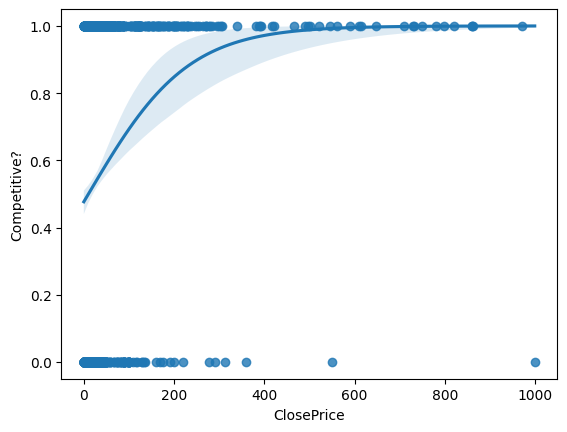

In [189]:
# j
sns.regplot(x='ClosePrice', y='Competitive?', data=auction_df, logistic=True)


# j
This plot alone does not give much insight into a good cutoff value. The logistic regression model is multi-variate, and many variables have differing coefficients. Using PCA, plotting more variables, and varying cutoff values to obtain error rates are necessary to experimentally find a good cutoff value. Using the default of 0.5 suffices for this problem, since the error rates are not abnormally high. Adjusting the cutoff value will alter both the true negative and false positive error rates.

# k
An auction that lasts 10 days contributes most strongly to a competitive auction. The ending day has multiple candidates that all negatively contribute to a competitive auction.